<a href="https://colab.research.google.com/github/Rivi9/Laptop-Recommendation-System/blob/NLP-Model/Text_Classification_With_Stemming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Text Classification Model**

---



#### Install necessary libraries

In [1]:
pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199772 sha256=6309de8089a7d4efc3209cb71d52f7e9585dd9a051810f4b5910abddc1c8a524
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


#### Import necessary libraries

In [12]:
import re
import nltk
import fasttext
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#### Download necessary NLTK data

In [14]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Load the dataset

In [15]:
# Load the text classsification dataset
df = pd.read_csv("/content/Text Classification Laptops - New - Sheet1 (10).csv", names=["sentences", "category"], header=None)
print(df.shape)
df.head(6)

(744, 2)


,sentences,category
0,I use my laptop as a software engineer to writ...,IT
1,"As a graphic designer, I use my laptop to crea...",Creative_Design
2,"I use my laptop as a writer to craft stories, ...",Business_Professional
3,"As a musician, I use my laptop to compose musi...",Creative_Design
4,I use my laptop as a gamer to play online game...,Gaming
5,"As a student, I use my laptop to take online c...",Student_Education


In [18]:
# Drop NA values
df.dropna(inplace=True)

In [16]:
df.category.unique()

array(['IT', 'Creative_Design', 'Business_Professional', 'Gaming',
       'Student_Education', 'Basic'], dtype=object)

In [17]:
category_counts = df["category"].value_counts()
print(category_counts)

Basic                    149
Business_Professional    142
Student_Education        138
IT                       112
Gaming                   103
Creative_Design          100
Name: category, dtype: int64


#### Preprocess the text data

*   Removing punctuation
*   Convert to lowercase
*   Remove extra spaces
*   Tokenize
*   Remove stopwords
*   Perform stemming

In [19]:
# Combine label and sentences with a preprocessing step
df['category'] = '__label__' + df['category'].astype(str)

stop_words = set(stopwords.words('english'))

def preprocess_with_stemming(text):
    # Remove punctuation and make lowercase
    text = re.sub(r'[^\w\s]', '', text).lower()
    # Remove extra spaces
    text = re.sub(' +', ' ', text)
    # Tokenization and stop words removal
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    # Stemming
    porter = PorterStemmer()
    stemmed_text = [porter.stem(word) for word in filtered_text]
    return ' '.join(stemmed_text)

df['sentence_description'] = df['category'] + ' ' + df['sentences'].map(preprocess_with_stemming)


#### Split data for training and testing

In [24]:
# Split data for training and testing
train, test = train_test_split(df, test_size=0.2)

# Save training and testing data to files
train.to_csv("laptop.train", columns=["sentence_description"], index=False, header=False)
test.to_csv("laptop.test", columns=["sentence_description"], index=False, header=False)

#### Train the FastText model

In [25]:
# Train the FastText model
model = fasttext.train_supervised(input="laptop.train", lr=0.5, epoch=25, wordNgrams=2, minCount=1)

(149, 0.7919463087248322, 0.7919463087248322)


#### Evaluate model performance

In [26]:
# Evaluate and print model performance
print(model.test("laptop.test"))

(149, 0.7919463087248322, 0.7919463087248322)


#### Confusion Matrix and Classification Report

<ipython-input-28-68ff2447efc7>:5: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  test_df[['true_labels', 'sentences']] = test_df['sentence_description'].str.split(' ', 1, expand=True)


Confusion Matrix:
[[24  3  0  1  0  0]
 [ 4 14  0  0  4  2]
 [ 3  1 22  0  1  0]
 [ 3  1  0 22  0  0]
 [ 2  1  1  0 12  4]
 [ 1  1  0  0  0 22]]

Classification Report:
                       precision    recall  f1-score   support

                Basic       0.65      0.86      0.74        28
Business_Professional       0.67      0.58      0.62        24
      Creative_Design       0.96      0.81      0.88        27
               Gaming       0.96      0.85      0.90        26
                   IT       0.71      0.60      0.65        20
    Student_Education       0.79      0.92      0.85        24

             accuracy                           0.78       149
            macro avg       0.79      0.77      0.77       149
         weighted avg       0.79      0.78      0.78       149



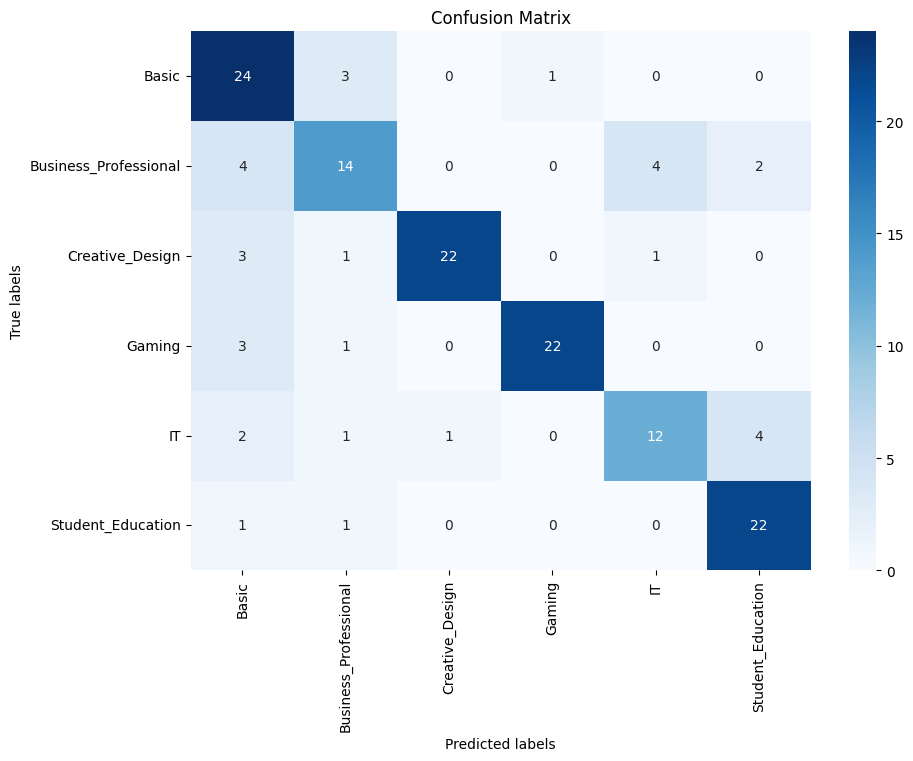

In [28]:
# Load the test data
test_df = pd.read_csv("laptop.test", names=["sentence_description"])

# Separate the labels and sentences
test_df[['true_labels', 'sentences']] = test_df['sentence_description'].str.split(' ', 1, expand=True)

# Preprocess the sentences in the test set
test_df['processed_sentences'] = test_df['sentences'].apply(lambda x: preprocess_with_stemming(x))

# Predict labels for the test set
test_df['predicted_labels'] = test_df['processed_sentences'].apply(lambda x: model.predict(x)[0][0])

# Extract the labels (removing the '__label__' prefix for comparison and reporting)
test_df['true_labels'] = test_df['true_labels'].str.replace('__label__', '')
test_df['predicted_labels'] = test_df['predicted_labels'].str.replace('__label__', '')

# Generate and print the confusion matrix
labels = np.unique(test_df['true_labels'])
conf_matrix = confusion_matrix(test_df['true_labels'], test_df['predicted_labels'], labels=labels)
print("Confusion Matrix:")
print(conf_matrix)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(test_df['true_labels'], test_df['predicted_labels'], target_names=labels))

# Plot confusion matrix in blue
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Test with custom inputs

In [27]:
def predict_category(sentence):
    preprocessed_sentence = preprocess_with_stemming(sentence)  # preprocessing the inputs
    return model.predict(preprocessed_sentence)

# Test with a custom sentence
print(predict_category("I need a laptop for gaming and school"))

(('__label__Gaming',), array([0.96068192]))


In [36]:
sentences = [
    "I need a powerful machine for video editing and graphic design work.",
    "Looking for a budget-friendly laptop for my college assignments.",
    "I require a laptop with high security and robust performance for my business operations.",
    "Seeking a laptop that can handle programming and software development tasks efficiently.",
    "I want a simple laptop for browsing the internet, watching movies, and checking emails.",
    "Looking for a durable laptop that can withstand travel and outdoor use.",
    "Need a laptop with a long battery life for day-long classes and lectures.",
    "I need a laptop for a data science undergraduate",
    "I need a laptop for an Artificial Intelligence lecturer"
]

for sentence in sentences:
    prediction = predict_category(sentence)
    print(f"Sentence: '{sentence}'\nPredicted Category: {prediction}\n")


Sentence: 'I need a powerful machine for video editing and graphic design work.'
Predicted Category: (('__label__Creative_Design',), array([0.99945027]))

Sentence: 'Looking for a budget-friendly laptop for my college assignments.'
Predicted Category: (('__label__Basic',), array([0.68052059]))

Sentence: 'I require a laptop with high security and robust performance for my business operations.'
Predicted Category: (('__label__Business_Professional',), array([0.59083658]))

Sentence: 'Seeking a laptop that can handle programming and software development tasks efficiently.'
Predicted Category: (('__label__IT',), array([0.98903543]))

Sentence: 'I want a simple laptop for browsing the internet, watching movies, and checking emails.'
Predicted Category: (('__label__Basic',), array([0.97404802]))

Sentence: 'Looking for a durable laptop that can withstand travel and outdoor use.'
Predicted Category: (('__label__Basic',), array([0.96245366]))

Sentence: 'Need a laptop with a long battery life

#### Save the trained model

In [10]:
model.save_model("fasttext_modelStemming.bin")